# Benchmark Analysis

In [5]:
import sys  
!{sys.executable} -m pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 17.5 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 18.4 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 19.5 MB/s eta 0:00:000:00:0136m0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 18.1 MB/s eta 0:00:00
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 20.3 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 21.0 MB/s eta 0:00:0031m22.5 MB/s eta 0:00:01
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached pytz-2022.7.1-py2.py3-none-any.whl (499 kB)

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [210]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pathlib import Path
from typing import List

%matplotlib inline

In [30]:
root_dir = '/Users/diego/Desktop/BENCHMARK_COLLECTED_NEBULAH_B1-B4_1'

## Utils 

In [39]:
def get_path(*entries):
    return os.path.join(*entries)    


In [19]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

## Cleaning input files
The benchmark csv's are not parseable csv's because they have a header that is not valid csv. We first need to strip this away.

In [31]:
def clean_file_content(input_filename,output_filename):
    with open(input_filename, 'r+') as fr: 
            lines = fr.readlines()
    
    with open(output_filename, 'w+') as fw: 
            reached = False

            for line in lines:
                if line.startswith('name,iterations,real_time'):
                    reached = True

                if reached:
                    fw.write(line)

def clean_all_files(target_dir,target_prefix="cleaned"):
    for dirpath, dirnames, filenames in os.walk(target_dir):
        if not dirnames:
            print(dirpath, "has ", len(filenames), "files")
            final_files = [(os.path.join(dirpath,x),os.path.join(dirpath,target_prefix,x)) for x in filenames]

            for input_filename, output_filename in final_files:
                ensure_file_existence(output_filename)
                clean_file_content(input_filename,output_filename)    
    print("Done!")


In [32]:
clean_all_files("/Users/diego/Desktop/BENCHMARK_COLLECTED_NEBULAH_B1-B4_1")
# in this case the location of the cleaned files will be /[DEFAULT|NUMACTL]/cleaned

/Users/diego/Desktop/BENCHMARK_COLLECTED_NEBULAH_B1-B4_1/NVHPC_Multicore/DEFAULT/cleaned has  65 files
/Users/diego/Desktop/BENCHMARK_COLLECTED_NEBULAH_B1-B4_1/GCC_TBB/DEFAULT/cleaned has  66 files
Done!


## B1_1 - Linear GCC VS NVHC (Multicore)
First we take a look at the speedup compared 

In [194]:
df = pd.read_csv(root_dir+'/GCC_TBB/DEFAULT/cleaned/b1_1_for_each_linear_par_Default.csv')

In [195]:
# dropping columns we do not care about
df = df.drop(['iterations','bytes_per_second','items_per_second','label','error_occurred','error_message'],axis=1)
df.head()

,name,real_time,cpu_time,time_unit
0,GCC_TBB_b1_1_for_each_linear_par/32,8259.150,8257.080,ns
1,GCC_TBB_b1_1_for_each_linear_par/32,8446.790,8443.770,ns
2,GCC_TBB_b1_1_for_each_linear_par/32_mean,8352.970,8350.420,ns
3,GCC_TBB_b1_1_for_each_linear_par/32_median,8352.970,8350.420,ns
4,GCC_TBB_b1_1_for_each_linear_par/32_stddev,132.676,132.016,ns


In [205]:
# adding the problem size as column
df = df[df['name'].str.endswith(('mean','median','stddev'))]
df['n'] = df.apply(lambda x: x[0][x[0].find('/')+1:x[0].rfind('_')],axis=1)

df = df.reset_index(drop=True)
df[:10]

,name,real_time,cpu_time,time_unit,n
0,GCC_TBB_b1_1_for_each_linear_par/32_mean,8352.97000,8350.42000,ns,32
1,GCC_TBB_b1_1_for_each_linear_par/32_median,8352.97000,8350.42000,ns,32
2,GCC_TBB_b1_1_for_each_linear_par/32_stddev,132.67600,132.01600,ns,32
3,GCC_TBB_b1_1_for_each_linear_par/64_mean,10148.10000,10145.70000,ns,64
4,GCC_TBB_b1_1_for_each_linear_par/64_median,10148.10000,10145.70000,ns,64
5,GCC_TBB_b1_1_for_each_linear_par/64_stddev,3.05203,2.90427,ns,64
6,GCC_TBB_b1_1_for_each_linear_par/128_mean,11992.60000,11989.80000,ns,128
7,GCC_TBB_b1_1_for_each_linear_par/128_median,11992.60000,11989.80000,ns,128
8,GCC_TBB_b1_1_for_each_linear_par/128_stddev,13.03410,12.85780,ns,128
9,GCC_TBB_b1_1_for_each_linear_par/256_mean,14621.90000,14618.70000,ns,256


In [204]:
# convert to format 
# name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
results_gcc.n = results_gcc.n.astype(int)
results_gcc = results_gcc.sort_values(['n'],ascending=True).reset_index(drop=True)

results_gcc['C'] = np.arange(len(results_gcc))

results_gcc['median_id'] = results_gcc['C']*3 + 1
results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

results_gcc['stddev_id'] = results_gcc['C']*3 + 2
results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])


results_gcc = results_gcc.drop(['C','median_id','stddev_id'],axis=1)
results_gcc['Compiler'] = 'GCC_TBB'
results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']),"").replace('/_mean',''),axis=1)

results_gcc

,name,real_time,cpu_time,time_unit,n,median,stddev,Compiler
0,GCC_TBB_b1_1_for_each_linear_par,8352.97,8350.42,ns,32,8352.97,132.67600,GCC_TBB
1,GCC_TBB_b1_1_for_each_linear_par,10148.10,10145.70,ns,64,10148.10,3.05203,GCC_TBB
2,GCC_TBB_b1_1_for_each_linear_par,11992.60,11989.80,ns,128,11992.60,13.03410,GCC_TBB
3,GCC_TBB_b1_1_for_each_linear_par,14621.90,14618.70,ns,256,14621.90,1.04927,GCC_TBB
4,GCC_TBB_b1_1_for_each_linear_par,18022.40,18011.00,ns,512,18022.40,24.16410,GCC_TBB
5,GCC_TBB_b1_1_for_each_linear_par,22146.40,22141.20,ns,1024,22146.40,129.32000,GCC_TBB
6,GCC_TBB_b1_1_for_each_linear_par,26265.00,26241.60,ns,2048,26265.00,61.80490,GCC_TBB
7,GCC_TBB_b1_1_for_each_linear_par,33608.20,33576.50,ns,4096,33608.20,57.32420,GCC_TBB
8,GCC_TBB_b1_1_for_each_linear_par,45238.40,45188.60,ns,8192,45238.40,87.96300,GCC_TBB
9,GCC_TBB_b1_1_for_each_linear_par,65941.40,65889.80,ns,16384,65941.40,122.84000,GCC_TBB


<Axes: xlabel='n'>

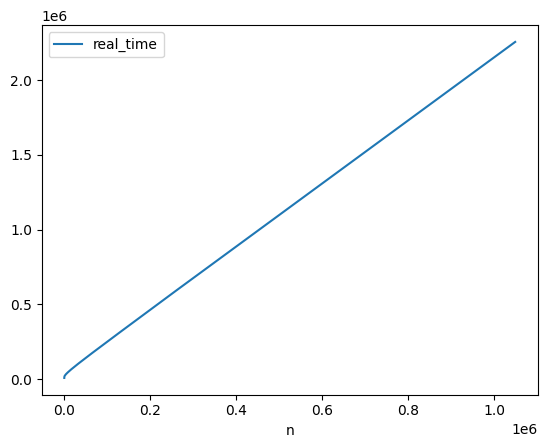

In [215]:
results_gcc.plot(x='n',y='real_time')

